# Team_7_Traffic_Dataset


## Import Necessary Libraries

In [1]:
# Core & utility
import os
import random
from glob import glob
from tqdm import tqdm

# Data manipulation & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
import cv2
from PIL import Image
from skimage.color import rgb2gray
from skimage.feature import hog

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, log_loss, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms

## Data loading

### For Google Colab User

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r "/content/drive/MyDrive/IT1244_Group/dataset" "/content/"
# root = "/content/drive/MyDrive/IT1244_Group/dataset"
# train_root = root + "/Train"
# test_root = root + "/Test"


In [3]:
def dataloader_to_numpy(dataloader):
    """
    Convert a PyTorch DataLoader into NumPy arrays.
    Returns:
        X: Flattened image data (N, 784)
        y: Corresponding labels (N,)
    """
    X_list, y_list = [], []
    for images, labels in dataloader:
        images = images.numpy()
        if images.ndim == 4:  # e.g., (B, 1, 28, 28)
            images = images.squeeze(1)
        X_list.append(images.reshape(images.shape[0], -1))  # Flatten to (B, 784)
        y_list.append(labels.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

## Data Modification and feature extraction

### 1. Normalised Raw Pixel Features

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the CSVs
train_df = pd.read_csv("../data/fashion-mnist_train.csv")
test_df = pd.read_csv("../data/fashion-mnist_test.csv")

# Split into X and y
X_train_full = train_df.iloc[:, 1:].values / 255.0
y_train_full = train_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values / 255.0
y_test = test_df.iloc[:, 0].values

# Split train/val (optional but useful for tuning)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

### 2. HOG(Histogram of Oriented Gradients) Features

In [5]:
def extract_hog_features(image_list, size=(64, 64)):
    features = []
    hog = cv2.HOGDescriptor(_winSize=(64, 64), _blockSize=(16, 16), _blockStride=(8, 8), _cellSize=(8, 8), _nbins=9)
    for img in image_list:
        gray = img.resize(size).convert('L')
        arr = np.array(gray).astype('uint8')
        if arr.shape == (64, 64):
            feat = hog.compute(arr)
            if feat is not None:
                features.append(feat.flatten())
    return np.array(features)

### 3. SIFT(Scale-Invariant Feature Transform) Features (flattened)
* This function uses OpenCV to extract SIFT descriptors for each image.
* Each image is resized, converted to grayscale, and passed into SIFT.
* Using circle-mask with sift so only the center of the images are taken into account for descriptors
* To make all feature lengths the same, we just take the first few descriptors and flatten them.

In [6]:
from PIL import Image


def prepare_image_list(X_flat, size=(64, 64)):
    image_list = []
    for arr in X_flat:
        img = arr.reshape(28, 28).astype('uint8')
        pil_img = Image.fromarray(img).resize(size)
        image_list.append(pil_img)
    return image_list

In [7]:
def extract_sift_features(image_list, size=(64, 64)):
    sift = cv2.SIFT_create()
    features = []
    failed = 0
    for img in image_list:
        gray = img.resize(size).convert('L')
        arr = np.array(gray).astype('uint8')

        _, descriptors = sift.detectAndCompute(arr, None)
        if descriptors is not None:
            features.append(np.mean(descriptors, axis=0))
        else:
            failed += 1
            features.append(np.zeros(128))

    print(f"[INFO] {failed}/{len(image_list)} images had no descriptors.")
    return np.array(features)

### 4. PCA(Principal Component Analysis) Features

* These 4 types of modification will be trained for feature based ML models

## Model Training and Evaluation (Feature Based Machine Learning)


### Function for training and testing with different model types

<table>
<tr>
  <th>Modified Data</th>
  <th>Model List</th>
</tr>
<tr>
  <td>
    <ul>
      <li>Normalised</li>
      <li>HOG</li>
      <li>SIFT</li>
      <li>PCA</li>
    </ul>
  </td>
  <td>
    <ul>
      <li>Decision Tree</li>
      <li>Random Forest</li>
      <li>Logistic Regression</li>
      <li>KNN</li>
      <li>XGBoost</li>
      <li>SVM</li>
    </ul>
  </td>
</tr>
</table>

In [8]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type, scale=False):
    # Optional scaling (recommended for KNN and Logistic Regression)
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Model selection
    if model_type == "dt":
        model = DecisionTreeClassifier(
            random_state=42,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=3
        )
    elif model_type == "rf":
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            random_state=42
        )
    elif model_type == "lr":
        model = LogisticRegression(
            max_iter=500,         # reduce from 3000
            solver='saga',        # faster for large datasets, supports multiclass
            penalty='l2',
            C=1.0,                # default
            verbose=1             # shows convergence progress
        )
    elif model_type == "knn":
        model = KNeighborsClassifier(
            n_neighbors=5,
            weights='distance'
        )
    elif model_type == "xgb":
        model = XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42
        )
    elif model_type == "svm":
      model = SVC(
          C = 0.1,
          kernel = 'linear'
          )
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Predict probabilities if available
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:
        n_classes = len(np.unique(y_train))
        y_pred_proba = np.zeros((len(y_pred), n_classes))
        for i, pred in enumerate(y_pred):
            y_pred_proba[i, pred] = 1.0

    # Classification metrics
    print("=== Evaluation Results ===")
    print(f"Model: {model_type.upper()}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro', zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, average='macro', zero_division=0))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro', zero_division=0))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix ({model_type.upper()})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Log Loss
    try:
        logloss = log_loss(y_test, y_pred_proba)
        print(f"Log Loss: {logloss:.4f}")
    except:
        print("Log Loss could not be calculated (possibly due to invalid probabilities).")

    # ROC AUC (multi-class)
    try:
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
        print(f"ROC AUC (macro): {roc_auc:.4f}")
    except:
        print("ROC AUC could not be calculated (likely due to class imbalance or missing labels).")

### Run 5 different models with 4 different modifed dataset (Normalised, HOG, SIFT, PCA)

#### 1. Normalized Raw data

In [9]:
# Normalised Raw pixel Features

# train_and_evaluate_model(X_train, y_train, X_test, y_test,model_type="knn",scale=True)
# train_and_evaluate_model(X_train, y_train, X_test, y_test,model_type="svm",scale=True)
# train_and_evaluate_model(X_train, y_train, X_test, y_test,model_type="lr",scale=True)
# train_and_evaluate_model(X_train, y_train, X_test, y_test,model_type="rf")
# train_and_evaluate_model(X_train, y_train, X_test, y_test,model_type="xgb")



#### 2. HOG Features

In [10]:

def extract_hog_features(image_list, size=(64, 64)):
    features = []
    hog = cv2.HOGDescriptor(
        _winSize=size,
        _blockSize=(16, 16),
        _blockStride=(8, 8),
        _cellSize=(8, 8),
        _nbins=9
    )
    for img in image_list:
        arr = np.array(img)
        feat = hog.compute(arr)
        if feat is not None:
            features.append(feat.flatten())
    return np.array(features)

In [11]:
# Convert to PIL and extract HOG
X_train_imgs = prepare_image_list(X_train)
X_val_imgs = prepare_image_list(X_val)
X_test_imgs = prepare_image_list(X_test)

X_train_hog = extract_hog_features(X_train_imgs)
X_val_hog = extract_hog_features(X_val_imgs)
X_test_hog = extract_hog_features(X_test_imgs)

# # Use HOG features with any model
# train_and_evaluate_model(X_train, y_train, X_test, y_test,model_type="knn",scale=True)
# train_and_evaluate_model(X_train, y_train, X_test, y_test,model_type="svm",scale=True)
# train_and_evaluate_model(X_train, y_train, X_test, y_test,model_type="lr",scale=True)
# train_and_evaluate_model(X_train, y_train, X_test, y_test,model_type="rf")
# train_and_evaluate_model(X_train, y_train, X_test, y_test,model_type="xgb")

#### 3. SIFT Features (Flattened)

In [12]:
# # Prepare PIL image lists
# X_train_imgs = prepare_image_list(X_train, size=(64, 64))
# X_test_imgs = prepare_image_list(X_test, size=(64, 64))

# # Extract SIFT features (slow step)
# X_train_sift = extract_sift_features(X_train_imgs)
# X_test_sift = extract_sift_features(X_test_imgs)


# # Check shape
# print(X_train_sift.shape)  # (N, 128)
# train_and_evaluate_model(X_train_sift, y_train, X_test_sift, y_test,model_type="knn",scale=True)
# train_and_evaluate_model(X_train_sift, y_train, X_test_sift, y_test,model_type="svm",scale=True)
# train_and_evaluate_model(X_train_sift, y_train, X_test_sift, y_test,model_type="lr",scale=True)
# train_and_evaluate_model(X_train_sift, y_train, X_test_sift, y_test,model_type="rf")
# train_and_evaluate_model(X_train_sift, y_train, X_test_sift, y_test,model_type="xgb")

#### 4. PCA on Raw Pixel Features

In [13]:
def extract_pca_features_train(image_list, size=(64, 64), n_components=0.95):
    data = []
    for img in image_list:
        img = img.resize(size)
        arr = np.array(img).astype('float32')
        data.append(arr.flatten())
    raw = np.array(data)
    pca = PCA(n_components=n_components, random_state=42)
    transformed = pca.fit_transform(raw)
    return transformed, pca

def extract_pca_features_test(image_list, pca, size=(64, 64)):
    data = []
    for img in image_list:
        img = img.resize(size)
        arr = np.array(img).astype('float32')
        data.append(arr.flatten())
    raw = np.array(data)
    return pca.transform(raw)

=== Evaluation Results ===
Model: KNN
Accuracy: 0.3135
Precision: 0.31767760705764647
Recall: 0.3135
F1 Score: 0.31127386104770827

Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.26      0.26      1000
           1       0.48      0.57      0.52      1000
           2       0.21      0.14      0.17      1000
           3       0.20      0.35      0.25      1000
           4       0.31      0.25      0.28      1000
           5       0.26      0.28      0.27      1000
           6       0.27      0.20      0.23      1000
           7       0.36      0.36      0.36      1000
           8       0.40      0.36      0.38      1000
           9       0.43      0.37      0.40      1000

    accuracy                           0.31     10000
   macro avg       0.32      0.31      0.31     10000
weighted avg       0.32      0.31      0.31     10000



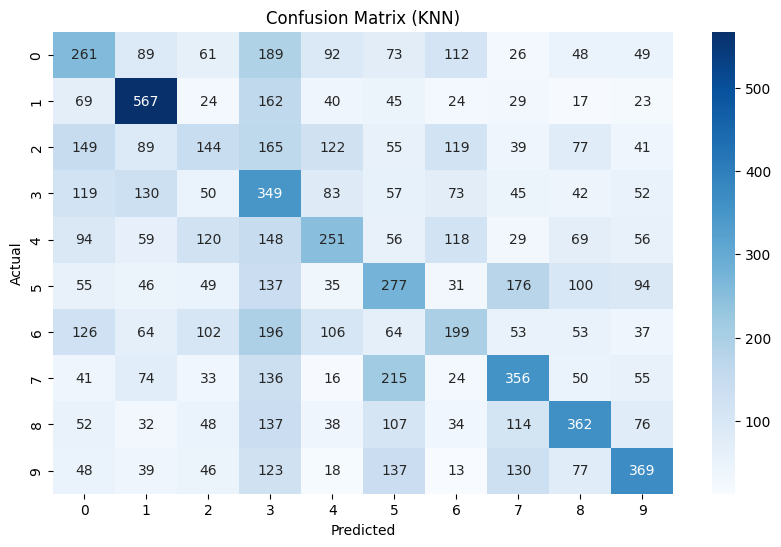

Log Loss: 13.2968
ROC AUC (macro): 0.7107
Epoch 1, change: 1
Epoch 2, change: 0.22296825
Epoch 3, change: 0.12535831
Epoch 4, change: 0.091335699
Epoch 5, change: 0.074361093
Epoch 6, change: 0.064224333
Epoch 7, change: 0.053935528
Epoch 8, change: 0.047765739
Epoch 9, change: 0.043761767
Epoch 10, change: 0.038676575
Epoch 11, change: 0.035461098
Epoch 12, change: 0.033068825
Epoch 13, change: 0.029882703
Epoch 14, change: 0.028386511
Epoch 15, change: 0.026670307
Epoch 16, change: 0.023996647
Epoch 17, change: 0.023573823
Epoch 18, change: 0.022428643
Epoch 19, change: 0.019808747
Epoch 20, change: 0.019564623
Epoch 21, change: 0.016880816
Epoch 22, change: 0.016127663
Epoch 23, change: 0.016050434
Epoch 24, change: 0.01577054
Epoch 25, change: 0.015539045
Epoch 26, change: 0.015289516
Epoch 27, change: 0.015028508
Epoch 28, change: 0.01482167
Epoch 29, change: 0.014662998
Epoch 30, change: 0.014455336
Epoch 31, change: 0.01423504
Epoch 32, change: 0.012101844
Epoch 33, change: 0.00

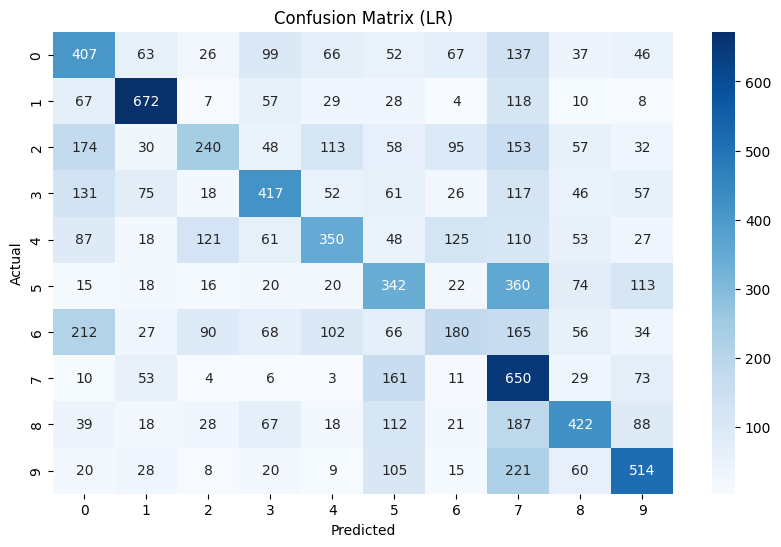

Log Loss: 1.6673
ROC AUC (macro): 0.8304
=== Evaluation Results ===
Model: RF
Accuracy: 0.3993
Precision: 0.4057364813104181
Recall: 0.39930000000000004
F1 Score: 0.3973996343474914

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.33      0.35      1000
           1       0.62      0.68      0.65      1000
           2       0.34      0.27      0.30      1000
           3       0.41      0.39      0.40      1000
           4       0.37      0.37      0.37      1000
           5       0.22      0.36      0.27      1000
           6       0.30      0.17      0.22      1000
           7       0.41      0.50      0.45      1000
           8       0.52      0.41      0.46      1000
           9       0.51      0.52      0.52      1000

    accuracy                           0.40     10000
   macro avg       0.41      0.40      0.40     10000
weighted avg       0.41      0.40      0.40     10000



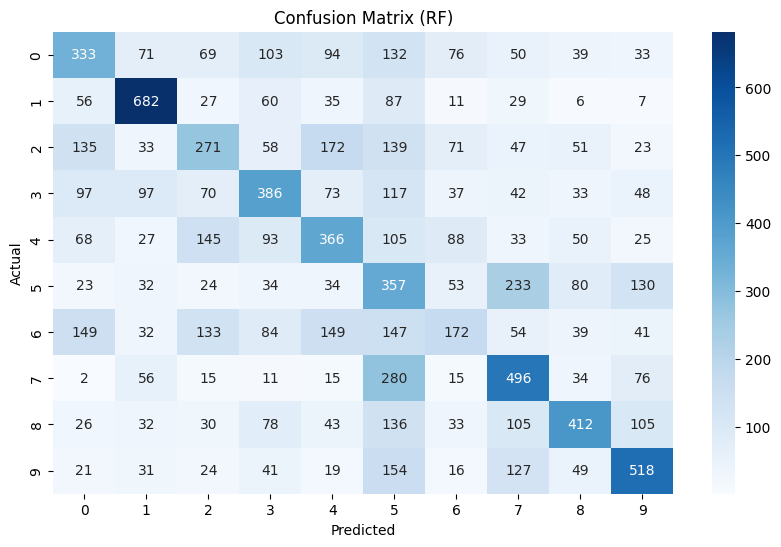

Log Loss: 1.8068
ROC AUC (macro): 0.8000


/opt/anaconda3/envs/cs3244/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:50:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Evaluation Results ===
Model: XGB
Accuracy: 0.434
Precision: 0.4483472407702325
Recall: 0.434
F1 Score: 0.4334163818074156

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.38      0.37      1000
           1       0.68      0.66      0.67      1000
           2       0.39      0.30      0.34      1000
           3       0.45      0.47      0.46      1000
           4       0.45      0.38      0.41      1000
           5       0.25      0.44      0.32      1000
           6       0.35      0.20      0.25      1000
           7       0.42      0.56      0.48      1000
           8       0.58      0.42      0.49      1000
           9       0.54      0.53      0.54      1000

    accuracy                           0.43     10000
   macro avg       0.45      0.43      0.43     10000
weighted avg       0.45      0.43      0.43     10000



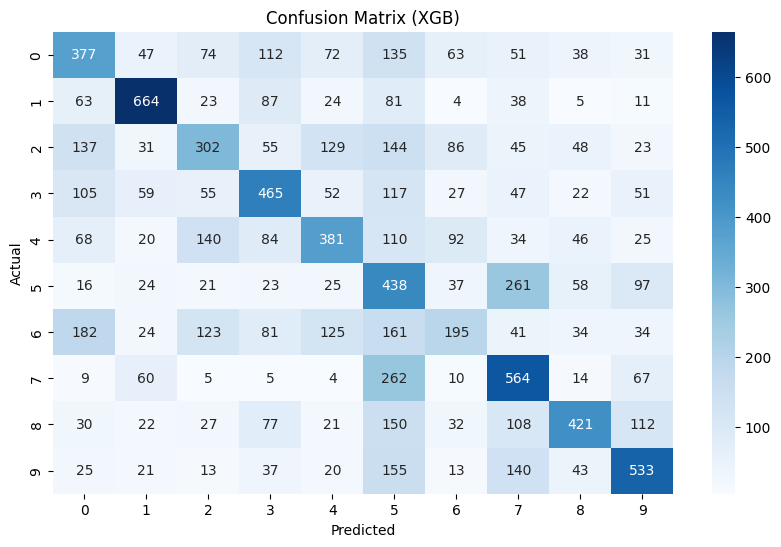

Log Loss: 1.5566
ROC AUC (macro): 0.8484


In [14]:
X_train_pca, pca = extract_pca_features_train(X_train_imgs, size=(64, 64), n_components=0.95)
X_test_pca = extract_pca_features_test(X_test_imgs, pca, size=(64, 64))

# Train and evaluate

train_and_evaluate_model(X_train_pca, y_train, X_test_pca, y_test,model_type="knn",scale=True)
#train_and_evaluate_model(X_train_pca, y_train, X_test_pca, y_test,model_type="svm",scale=True)
train_and_evaluate_model(X_train_pca, y_train, X_test_pca, y_test,model_type="lr",scale=True)
train_and_evaluate_model(X_train_pca, y_train, X_test_pca, y_test,model_type="rf")
train_and_evaluate_model(X_train_pca, y_train, X_test_pca, y_test,model_type="xgb")